In [1]:
'''
Import Libraries

'''

from sklearn.model_selection import KFold,StratifiedKFold,RepeatedStratifiedKFold
from sklearn.metrics import fbeta_score
from sklearn.feature_selection import SelectKBest,chi2
from imblearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.impute import KNNImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import MinMaxScaler,KBinsDiscretizer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer,SimpleImputer
from sklearn.linear_model import BayesianRidge,LogisticRegression,SGDClassifier
from sklearn.svm import LinearSVC
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
'''
Determine the Caregorical Variables

'''

MAX_UNIQUE_VALUES_FOR_CATEGORICAL=7
def is_categorical(data, columnName):
    return len(data[columnName].unique()) < MAX_UNIQUE_VALUES_FOR_CATEGORICAL

In [3]:
'''
Determine percent of datapoints that a Variable VariableName takes a value <featureVal>
for a TargetName taking a value <targetVal>

'''

def get_percentage(data,featureName,featureVal,targetName,targetVal):
    needed_data=data.loc[(data[featureName]==featureVal)&(data[targetName]==targetVal)]
    records_in_target_class=len(data.loc[data[targetName]==targetVal])
    perc=round(100*len(needed_data)/(1.0*records_in_target_class),2)
    return perc

In [4]:
'''
This function returns a comparison by percentage of the data 
distribution for a target variable for all possible values of a Variable. 
If the Variable is continuous, then it is discretized into certain number of classes, which is then encoded.
'''

def compare_features(new_data,selected_features,target_label):
    report={}
    report["features"]=[]
    for featureName in selected_features:
        featureReport={}
        featureReport["name"]=featureName
        featureReport["type"]="categorical"
        if not is_categorical(new_data,featureName):
            featureReport["type"]="continuous"
            discretizer=KBinsDiscretizer(n_bins=5,encode='ordinal',strategy='uniform')
            transformed_distance=pd.DataFrame(discretizer.fit_transform(new_data[[featureName]]))
            transformed_distance.columns=[featureName]
            # print('Inverse_values: {}'.format(discretizer.inverse_transform(pd.DataFrame({'distance':transformed_distance[featureName].unique()}))))
            new_data[featureName]=transformed_distance[featureName]
        featureReport["classDescription"]=[]
        for targetVal in new_data[target_label].unique():
            classReport={} 
            classReport["targetValue"]=targetVal
            classReport["description"]=[]
            for featureVal in new_data[featureName].unique():
                percentage=0
                try:
                    percentage=get_percentage(new_data,featureName,featureVal,target_label,targetVal)
                except ZeroDivisionError:
                    percentage=0
                classReport["description"].append({'featureVal':featureVal, 'percentage':percentage})
            featureReport["classDescription"].append(classReport)  
        report["features"].append(featureReport)
    return report

In [5]:
'''
This function is used to evaluate the performance of a given model against the provided data A pipeline is created 
with the following steps:

Scaler - MinMaxScaler(0,1) - to scale the values to the range 0-1
Oversampler - SMOTE(Synthetic Minority Oversampling Technique) - Used to oversample the minority class
Undersampler - RandomUnderSampler - Used to undersample the majority class
Feature Selector - SelectKBest - Used to select k best features
Model - The provided model to train
RepeatedStratifiedKFold approach is used for cross validation, stratified model is used since the class is imbalanced
'''

def evaluate_model(data,model):
    report = {}
    report["stats_by_iteration"]=[]
    iteration=1
    pipeline = Pipeline(steps=[('scaler',MinMaxScaler(feature_range=(0,1))),('o',SMOTE(sampling_strategy=0.2)),('u',RandomUnderSampler(sampling_strategy=0.5)),('selector',SelectKBest(chi2, k=6)), ('m', model)])
    y=data['outcome']
    X=data.drop(['outcome'],axis=1)
    num_splits=10
    num_repeats=5
    skf = RepeatedStratifiedKFold(n_splits=num_splits, n_repeats=num_repeats, random_state=42)
    
    for train_index, test_index in skf.split(X, y): 
        run_stats={}
        x_train_fold, x_test_fold = X.iloc[train_index], X.iloc[test_index] 
        y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index] 
        run_stats["iteration"]=iteration
        run_stats["repeat_number"]=iteration//num_splits
        run_stats["num_train_data"]=len(x_train_fold)
        run_stats["num_test_data"]=len(x_test_fold)
        pipeline.fit(x_train_fold, y_train_fold) 
        predictions=pipeline.predict(x_test_fold)
        run_stats["selected_features"]=X.columns[pipeline['selector'].get_support(indices=True)].tolist()
        f0_5_score = round(fbeta_score(y_test_fold,predictions,average='weighted',beta=0.5)*100,2)
        run_stats["f0.5"]=f0_5_score
        iteration+=1
        report["stats_by_iteration"].append(run_stats)
    return report

In [6]:
'''
This function is used to generate the heat map for the data
'''

def show_heat_map(data):
    correlation_matrix = data.corr()
    #To mask out the upper triangle
    plt.figure(figsize=(20,10))
    mask = np.zeros_like(correlation_matrix, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(data.corr(),mask=mask,annot=True)

In [7]:
'''
This function is used to identify the outliers for Variable
'''

def identify_outliers(data, featureName):
    mean = np.mean(data[featureName])
    stddev = np.std(data[featureName])
    indices = []
    for index,value in data[featureName].iteritems():
        z_score = (value-mean)/stddev
        if abs(z_score) > 3:
            indices.append(index)
    return indices

In [8]:
'''
Plots pie charts showing the percentage distribution of Variable values for a given target class
'''

def plot_data_from_report(report):
    index=0
    features_length=len(report["features"])
    fig,axj=plt.subplots(nrows=features_length//2,ncols=2,figsize=(8,8),dpi=200) #Create pie chart pits
    axes = axj.flatten() #Subgraph flattening
    for feature in report["features"]:
        for classDesc in feature["classDescription"]:
            if classDesc["targetValue"] != 1:
                continue
            actual_labels=[]
            percentages=[]
            for featureDescription in classDesc["description"]:
                percentages.append(featureDescription["percentage"])
                actual_labels.append('{}={}'.format(feature["name"],featureDescription["featureVal"]))
            patches, text, autotext=axes[index].pie(percentages,labels=[['']*len(actual_labels)][0],explode=[0.08]*len(actual_labels),autopct='%1.2f%%',textprops={'fontsize': 5},radius=0.9)
            axes[index].legend( actual_labels, loc='upper left', bbox_to_anchor=(-0.1, 1.),fontsize=5)
            plt.tight_layout()
            axes[index].set_title('Feature Description {} for Target {}'.format(feature["name"],"YES" if classDesc["targetValue"]==1 else "NO"),fontsize=5)
            plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=0.2) 
        index+=1

In [9]:
'''
Read The Data File
'''

data_file = 'DataSet_PCP_Change.csv'
data = pd.read_csv(data_file,index_col='testindex')
data.shape

(3130, 13)

In [10]:
'''
Check for Null Data Values
'''

print(data.isna().sum())


'''
Columns claims_daysaway and tier have null values.
tier is a categorical variable and can be replaced with the mode.
claims_days_away has significantly large null values and so we will drop the column for the analysis.
'''

outcome                 0
distance                0
visit_count             0
claims_daysaway      2574
tier                    9
fqhc                    0
pcp_lookback            0
family_assignment       0
kid                     0
is_ped                  0
same_gender             0
same_language           0
same_address            0
dtype: int64


'\nColumns claims_daysaway and tier have null values.\ntier is a categorical variable and can be replaced with the mode.\nclaims_days_away has significantly large null values and so we will drop the column for the analysis.\n'

In [11]:
data['tier'].fillna(data['tier'].mode()[0],inplace=True)
data.drop(['claims_daysaway'],axis=1,inplace=True)

'\noutcome : Data is highly imbalanced i.e data points with class label 0 exceeds the number of data points with label 1.\ndistance : the distribution is skewed\nvisit_count : the distribution is skewed\nOther binary attributes seem to be fairly distributed or slightly skewed\n\n'

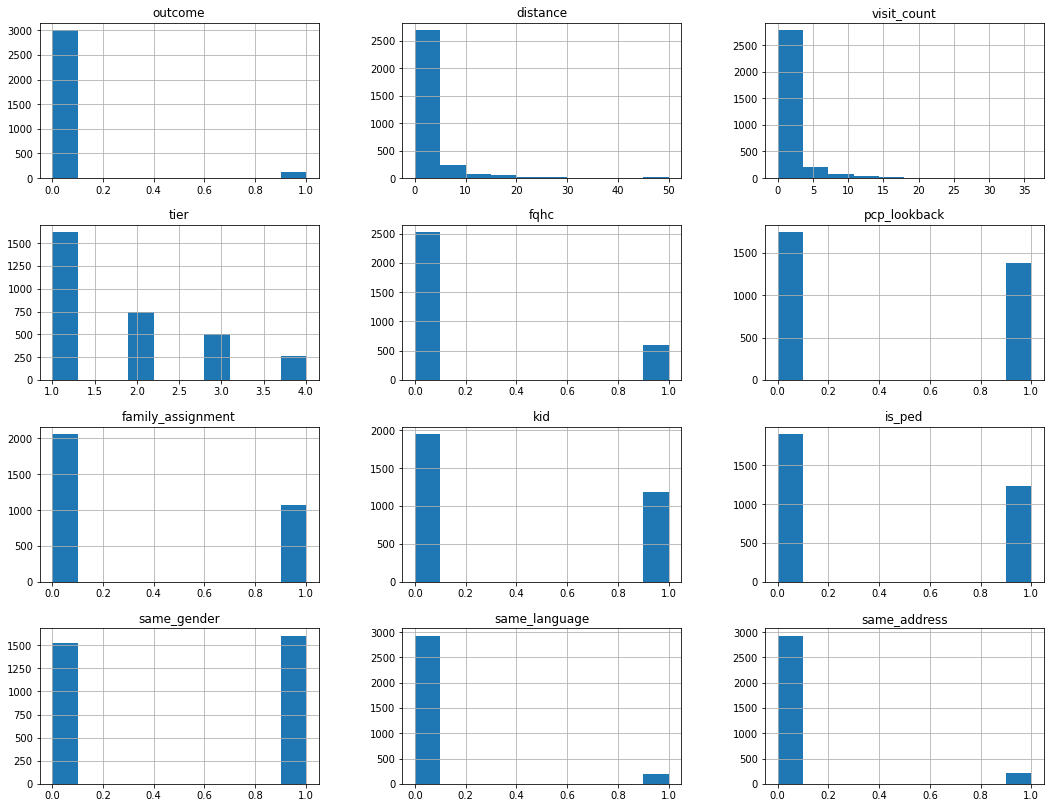

In [12]:
data.hist(figsize=(18,14))


'''
outcome : Data is highly imbalanced i.e data points with class label 0 exceeds the number of data points with label 1.
distance : the distribution is skewed
visit_count : the distribution is skewed
Other binary attributes seem to be fairly distributed or slightly skewed

'''

In [13]:
'''
Check Data for skewness
'''

print(data.skew())

'''
As observed from the histogram, distance and visit_count are highly skewed(right-skewed or positively skewed).
We will apply a logarithm transformation to reduce the skewness.
log (x+1) - +1 is included to prevent values from going to infinity
'''

outcome              4.659267
distance             4.876756
visit_count          4.778858
tier                 0.903941
fqhc                 1.561988
pcp_lookback         0.232984
family_assignment    0.667141
kid                  0.507856
is_ped               0.441229
same_gender         -0.047320
same_language        3.535541
same_address         3.514287
dtype: float64


'\nAs observed from the histogram, distance and visit_count are highly skewed(right-skewed or positively skewed).\nWe will apply a logarithm transformation to reduce the skewness.\nlog (x+1) - +1 is included to prevent values from going to infinity\n'

In [14]:
'''
Check Data for skewness
'''

data.distance=data.distance.map(lambda x: np.log(x+1))
data.visit_count=data.visit_count.map(lambda x: np.log(x+1))
print(data.skew())

'''
Skewness Reduced
'''

outcome              4.659267
distance             1.484972
visit_count          2.154438
tier                 0.903941
fqhc                 1.561988
pcp_lookback         0.232984
family_assignment    0.667141
kid                  0.507856
is_ped               0.441229
same_gender         -0.047320
same_language        3.535541
same_address         3.514287
dtype: float64


'\nSkewness Reduced\n'

<AxesSubplot:>

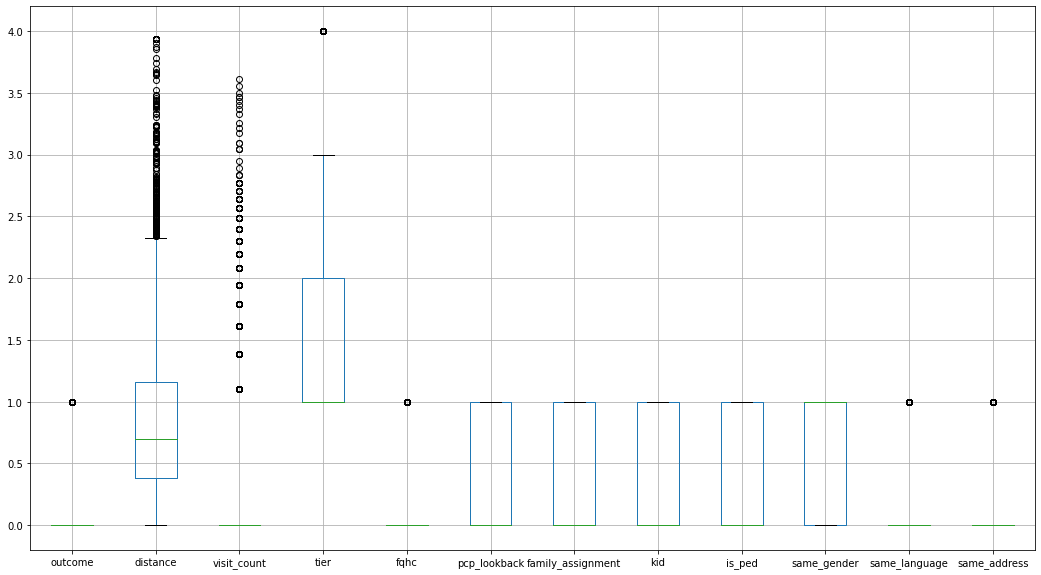

In [15]:
'''
We use box plot to check for outliers
'''

data.boxplot(figsize=(18,10))

In [16]:
'''
Remove outliers from the dataset
'''


distance_outliers=identify_outliers(data,'distance')
visit_count_outliers=identify_outliers(data,'visit_count')
data.drop(distance_outliers,inplace=True)
#Drop the indices that are common for both the outliers
visit_count_outliers=[index for index in visit_count_outliers if index not in distance_outliers] 
data.drop(visit_count_outliers,inplace=True)
print('Removed {} outliers from the dataset'.format(len(distance_outliers)+len(visit_count_outliers)))
print(data.shape)

Removed 123 outliers from the dataset
(3007, 12)


C:\Users\Bablu\AppData\Local\Temp/ipykernel_16432/1289052023.py:9: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(correlation_matrix, dtype=np.bool)


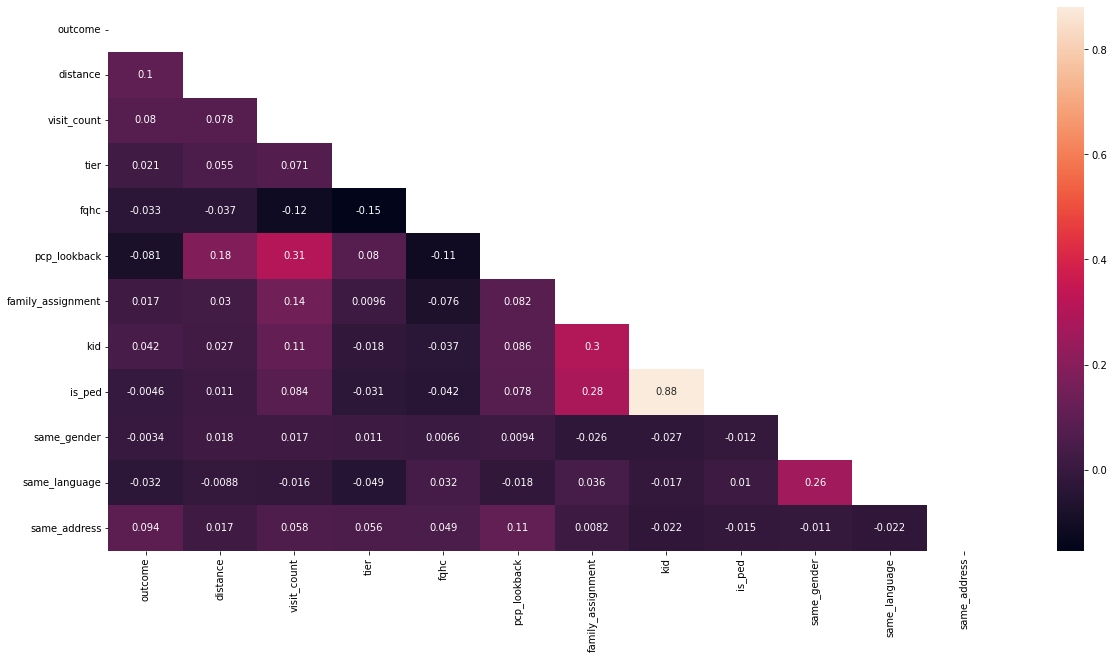

In [17]:
'''
Plot Heat map to identify positive correlation
'''

show_heat_map(data)



In [18]:

'''
From the above heatmap, there is a very obvious strong positive correlation.
Features kid and is_ped are highly correlated
if the person is a kid then the assigned doctor is a pediatrician
This Feature can be closed
'''

data.drop(['is_ped'],axis=1,inplace=True)

In [19]:
'''
Model Selection¶
The following models are selected to be evaluated

RandomForestClassifier
Gaussian Naive Bayes Classifier
Logistic Regression
Linear Suport Vector Classification
k Nearest Neighbors
Decision Tree Classifier

'''



models=[{'name':'RandomForest', 'model': RandomForestClassifier()},{'name':'GaussianNB','model':GaussianNB()},{'name':'LogisticRegression','model':LogisticRegression()},{'name':'LinearSVC','model':LinearSVC()},{'name':'kNN','model':KNeighborsClassifier(n_neighbors=10,weights='distance')},{'name':'DecisionTree','model':DecisionTreeClassifier()}]
analysis=[]
for model in models:
    model_training_report=evaluate_model(data,model["model"])
    model_training_report["name"]=model["name"]
    condensed_data=[(item["iteration"],item["f0.5"])for item in model_training_report["stats_by_iteration"]]
    model_training_report["analysis_result"]=condensed_data
    analysis.append(model_training_report)

Least variance for model {'name': 'LinearSVC', 'variance': 0.6511694400000003, 'max_score': 95.06}


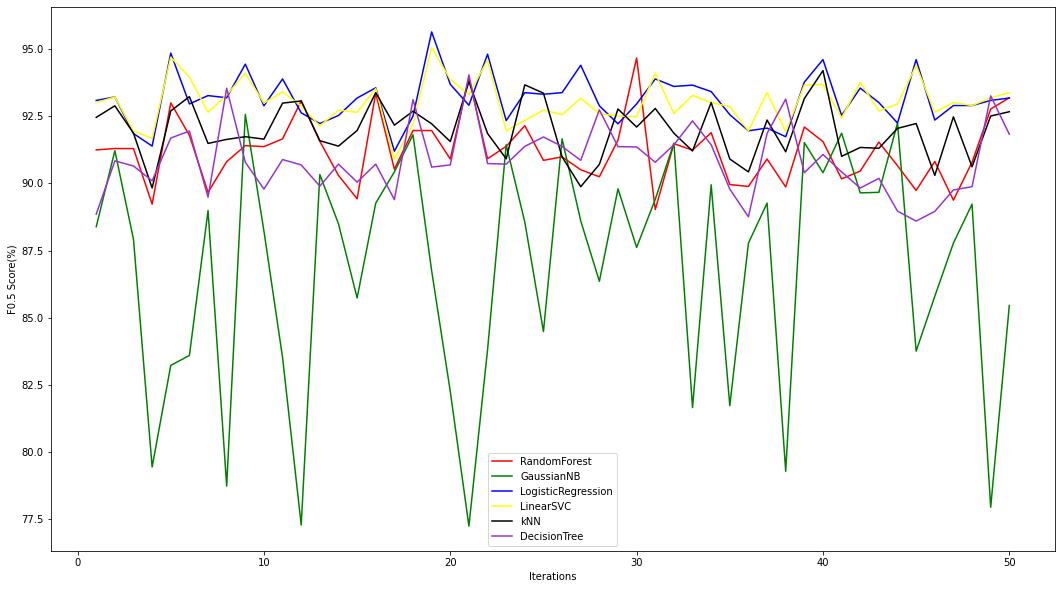

In [20]:
'''
Model Evaluation : 
We check the performance of the model using the RepeatedStratifiedKFold 
cross validation technique and record the f0.5 score for each iteration.

We use this data to compare the models.
The reason we use f0.5 score instead of the usual metrics is because the data is imbalanced 
i.e. class to be learned is the minority class and as the false positives are costly.

'''

plt.figure(figsize=(18,10))
plt.xlabel('Iterations')
plt.ylabel('F0.5 Score(%)')

colors=["red",'green','blue','yellow','black','darkorchid','lime']
index=0
model_names=[]
variances=[]
for analysis_res in analysis:
    condensed_data = analysis_res["analysis_result"]
    model_names.append(analysis_res['name'])
    percentages=[item[1] for item in condensed_data]
    variances.append({'name':analysis_res['name'],'variance':np.var(percentages),'max_score':max(percentages)})
    plt.plot([item[0] for item in condensed_data],percentages,color=colors[index])
    index+=1
plt.legend(model_names)
variances=sorted(variances,key=lambda x: x['variance'])
print('Least variance for model {}'.format(variances[0]))

In [21]:
for i in variances:
    print("Variance for model : {}".format(i))



Variance for model : {'name': 'LinearSVC', 'variance': 0.6511694400000003, 'max_score': 95.06}
Variance for model : {'name': 'LogisticRegression', 'variance': 0.8257619599999996, 'max_score': 95.64}
Variance for model : {'name': 'kNN', 'variance': 1.0209126400000006, 'max_score': 94.2}
Variance for model : {'name': 'RandomForest', 'variance': 1.43889024, 'max_score': 94.67}
Variance for model : {'name': 'DecisionTree', 'variance': 1.577513000000002, 'max_score': 94.04}
Variance for model : {'name': 'GaussianNB', 'variance': 18.266256839999993, 'max_score': 92.57}


In [22]:
'''
Linear Suport Vector Classifier is the model with the least variance across the iterations, 
meaning that the performance of the model is consistent
'''

chosenModel="LinearSVC"
featureVotes={}
for model in analysis:
  if model["name"]==chosenModel:
    for iteration_stats in model["stats_by_iteration"]:
      for feature in iteration_stats["selected_features"]:
        if feature not in featureVotes:
          featureVotes[feature]=0
        featureVotes[feature]+=1
# print(featureVotes)
selected_features=sorted(featureVotes, key=featureVotes.get,reverse=True)[:6]
print("Top 6 important features are {}".format(selected_features))

Top 6 important features are ['pcp_lookback', 'same_address', 'visit_count', 'fqhc', 'distance', 'same_language']


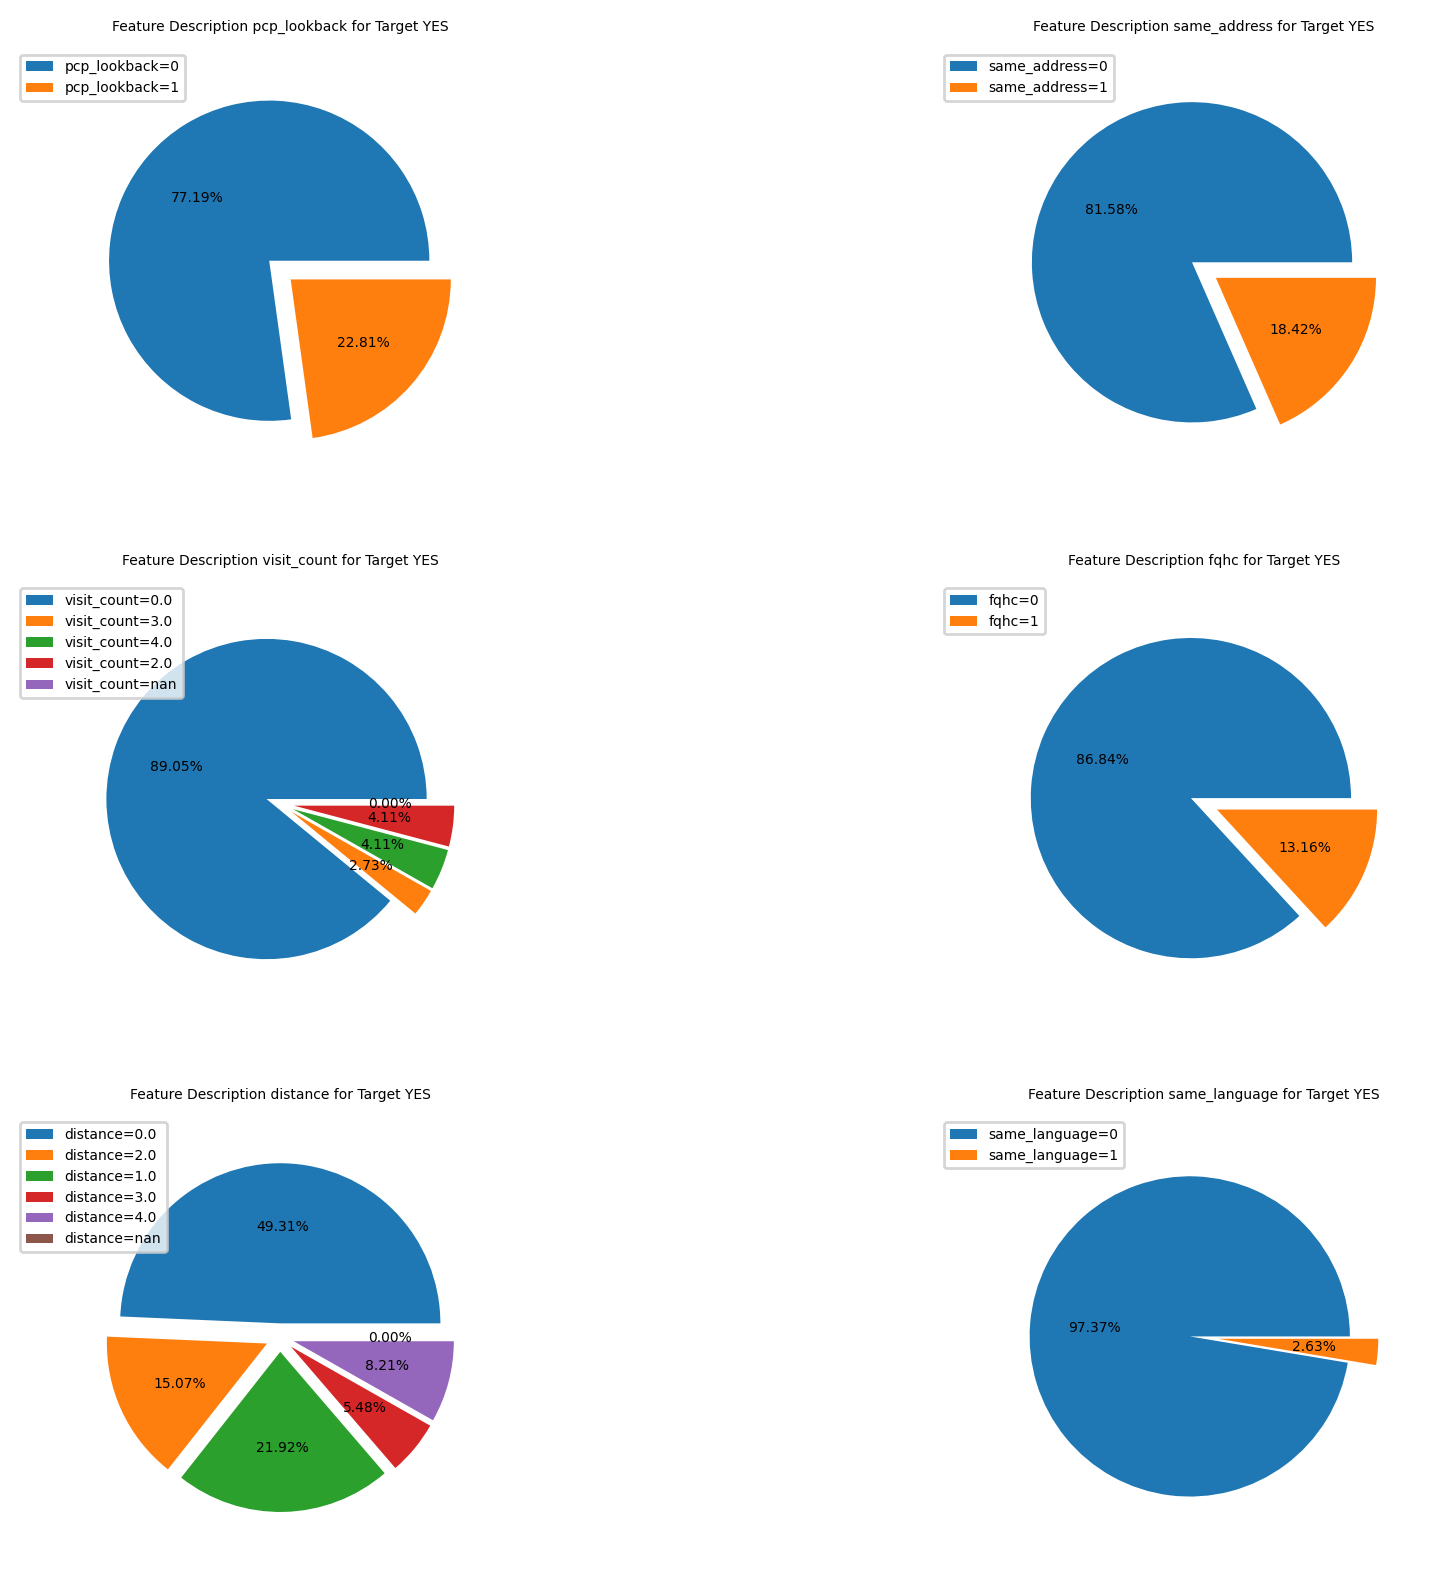

In [23]:
target_label='outcome'
report=compare_features(data,selected_features, target_label)
# print(report)
plot_data_from_report(report)
plt.show()

In [24]:
chosenModel="RandomForest"
featureVotes={}
for model in analysis:
  if model["name"]==chosenModel:
    for iteration_stats in model["stats_by_iteration"]:
      for feature in iteration_stats["selected_features"]:
        if feature not in featureVotes:
          featureVotes[feature]=0
        featureVotes[feature]+=1
# print(featureVotes)
selected_features=sorted(featureVotes, key=featureVotes.get,reverse=True)[:6]
print("Top 6 important features are {}".format(selected_features))

Top 6 important features are ['pcp_lookback', 'same_address', 'visit_count', 'same_language', 'distance', 'fqhc']


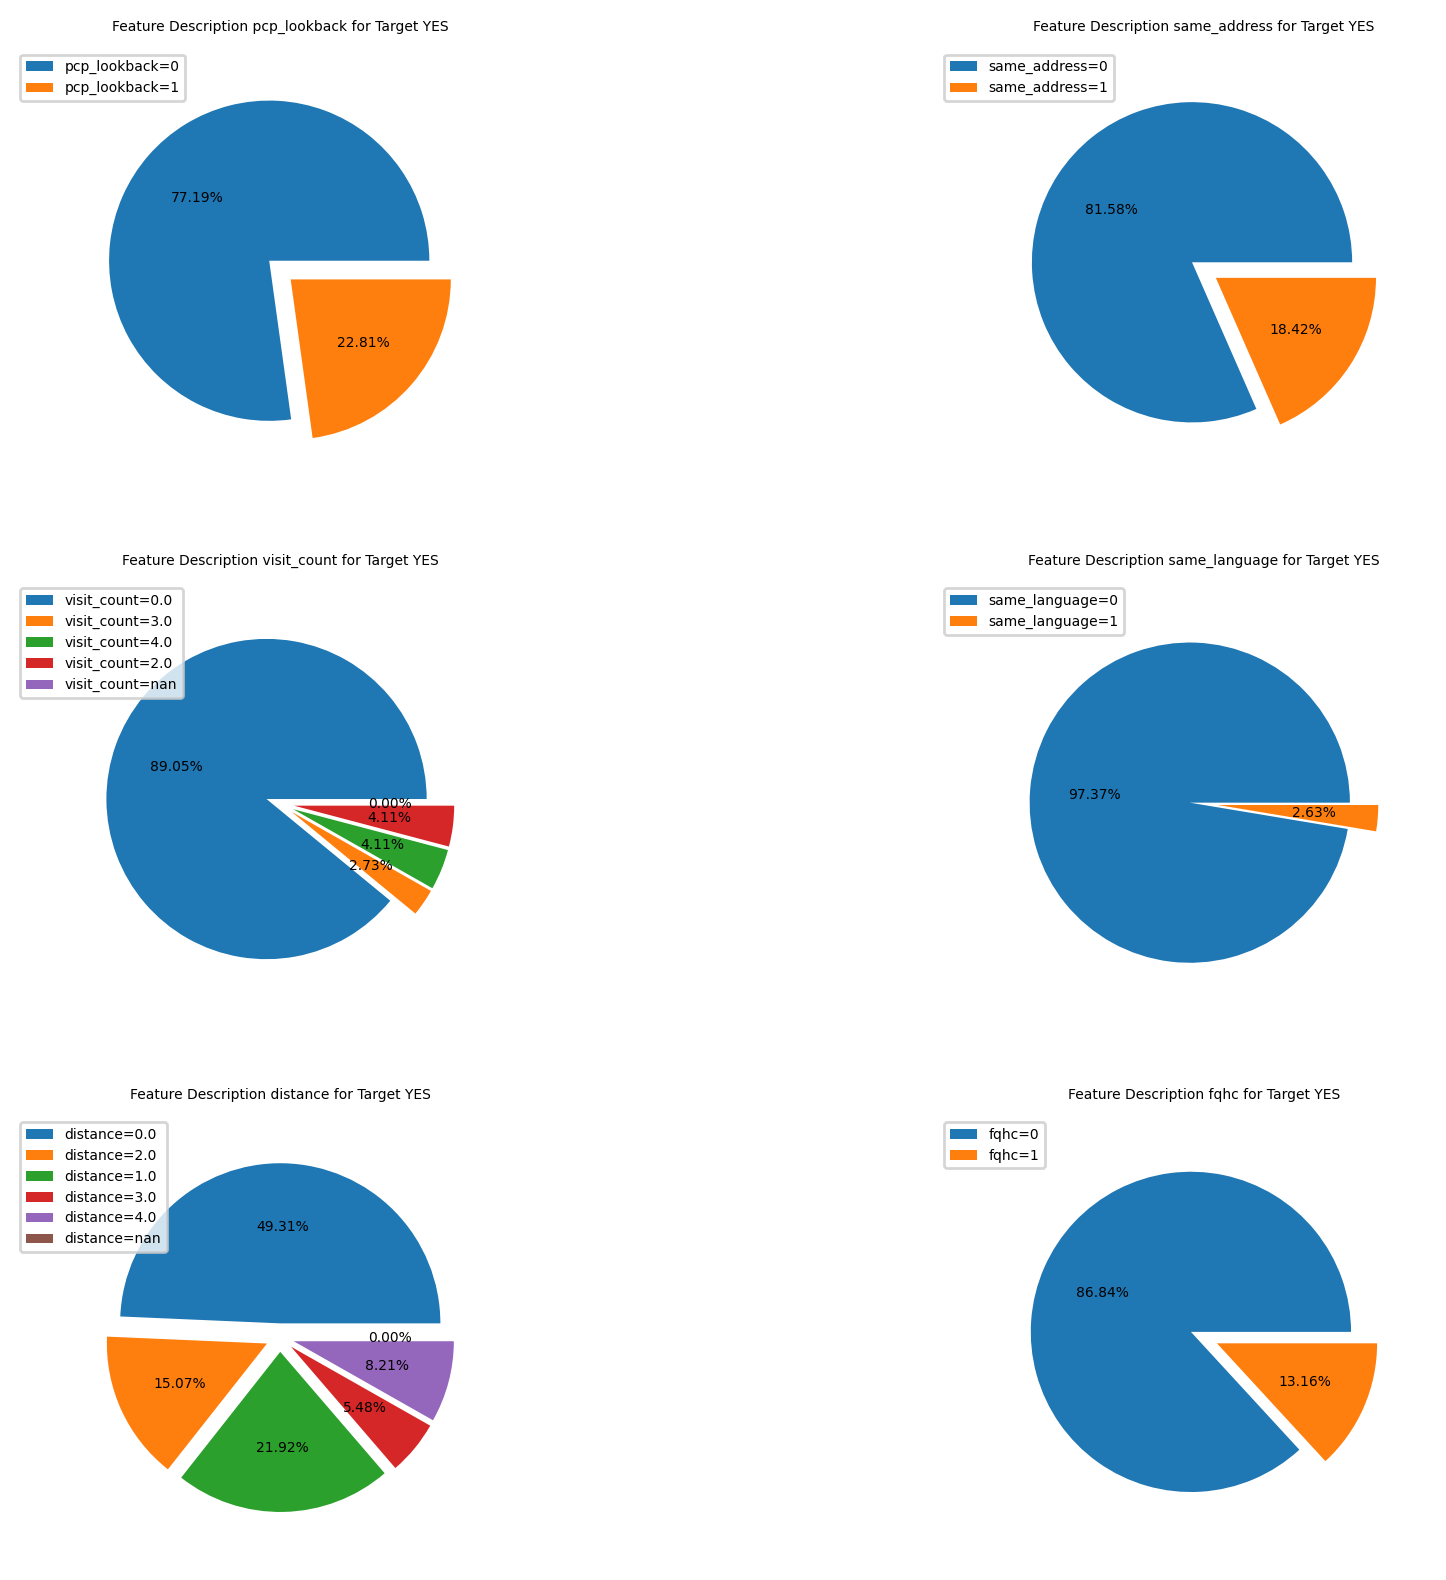

In [25]:
target_label='outcome'
report=compare_features(data,selected_features, target_label)
# print(report)
plot_data_from_report(report)
plt.show()

In [26]:
chosenModel="GaussianNB"
featureVotes={}
for model in analysis:
  if model["name"]==chosenModel:
    for iteration_stats in model["stats_by_iteration"]:
      for feature in iteration_stats["selected_features"]:
        if feature not in featureVotes:
          featureVotes[feature]=0
        featureVotes[feature]+=1
# print(featureVotes)
selected_features=sorted(featureVotes, key=featureVotes.get,reverse=True)[:6]
print("Top 6 important features are {}".format(selected_features))

Top 6 important features are ['pcp_lookback', 'same_address', 'visit_count', 'same_language', 'fqhc', 'distance']


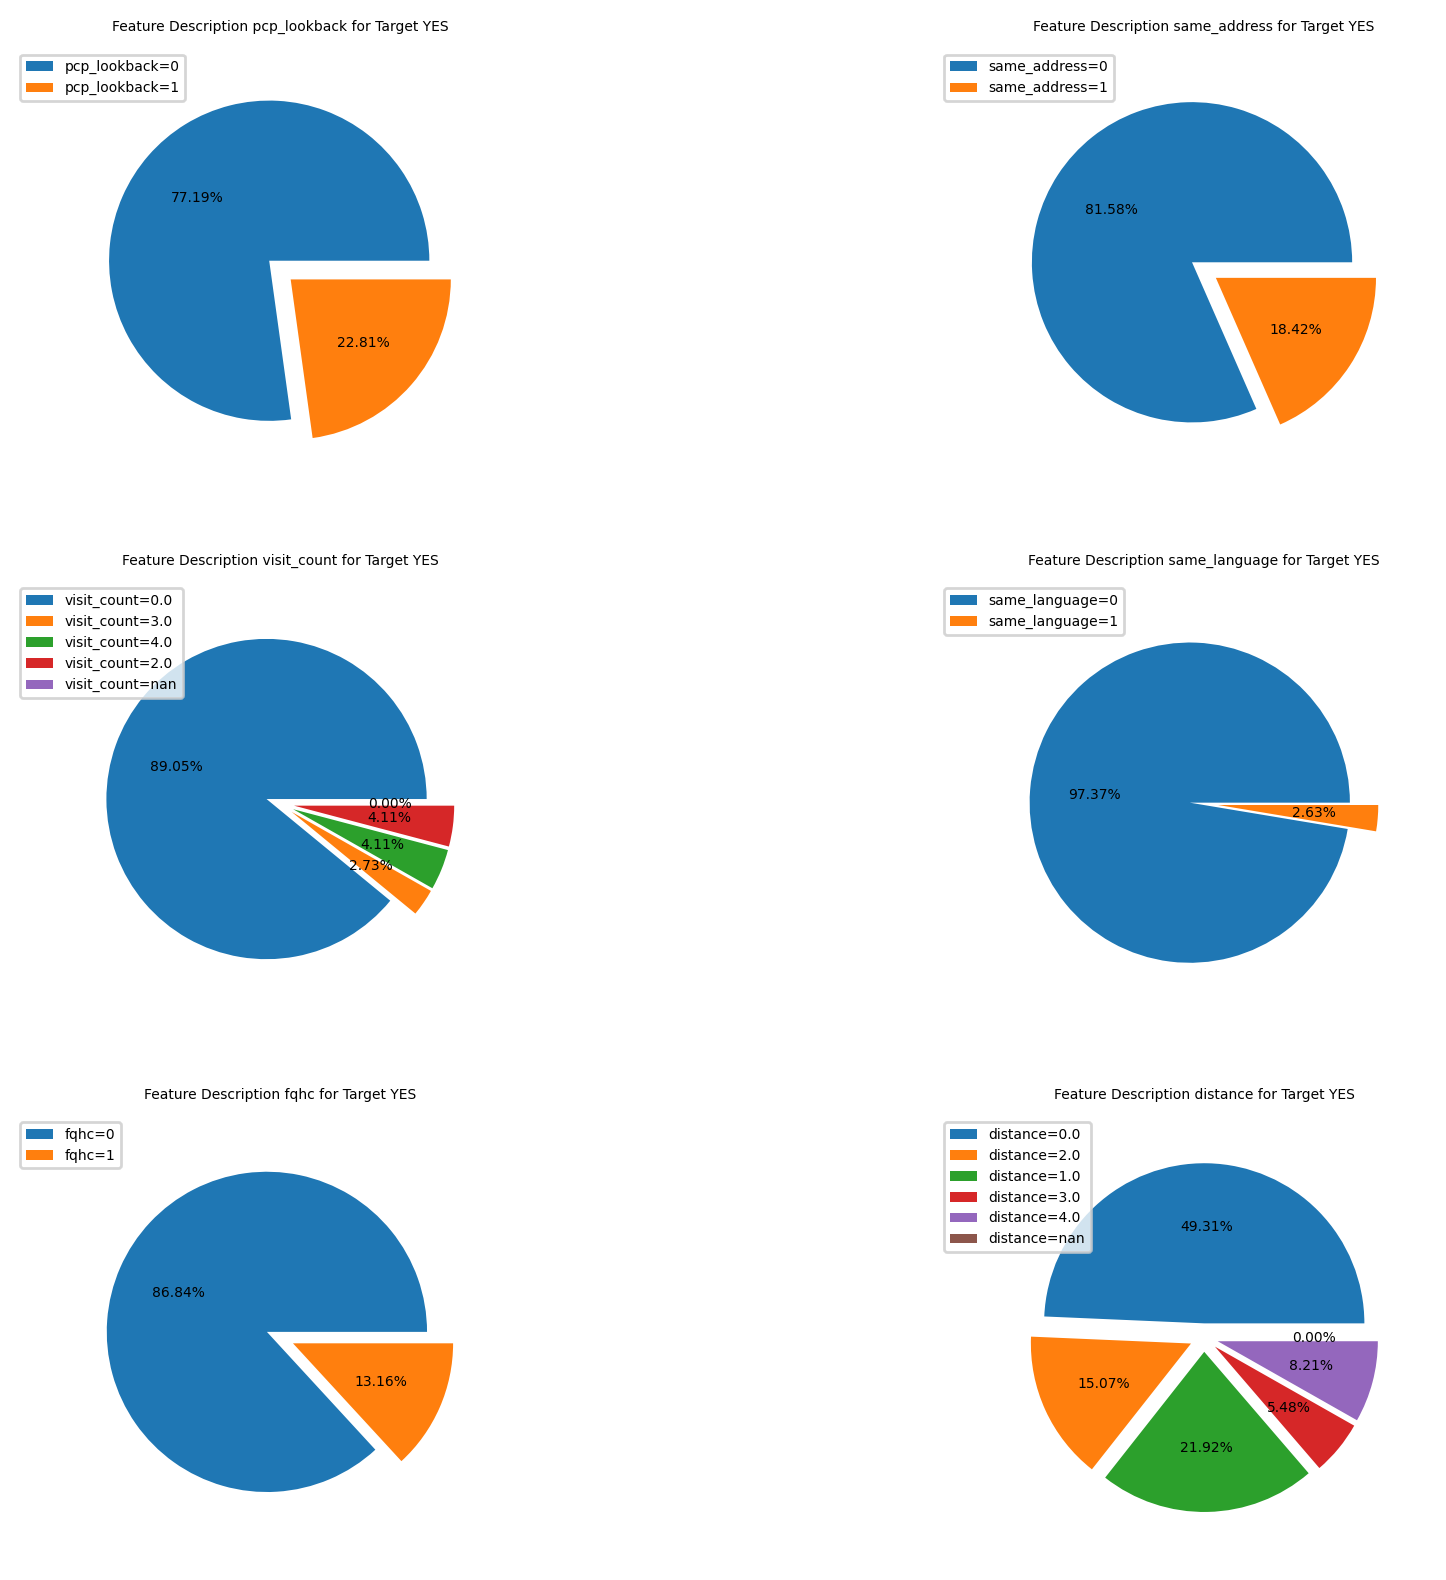

In [27]:
target_label='outcome'
report=compare_features(data,selected_features, target_label)
# print(report)
plot_data_from_report(report)
plt.show()

In [28]:
chosenModel="LogisticRegression"
featureVotes={}
for model in analysis:
  if model["name"]==chosenModel:
    for iteration_stats in model["stats_by_iteration"]:
      for feature in iteration_stats["selected_features"]:
        if feature not in featureVotes:
          featureVotes[feature]=0
        featureVotes[feature]+=1
# print(featureVotes)
selected_features=sorted(featureVotes, key=featureVotes.get,reverse=True)[:6]
print("Top 6 important features are {}".format(selected_features))

Top 6 important features are ['pcp_lookback', 'same_address', 'visit_count', 'fqhc', 'distance', 'same_language']


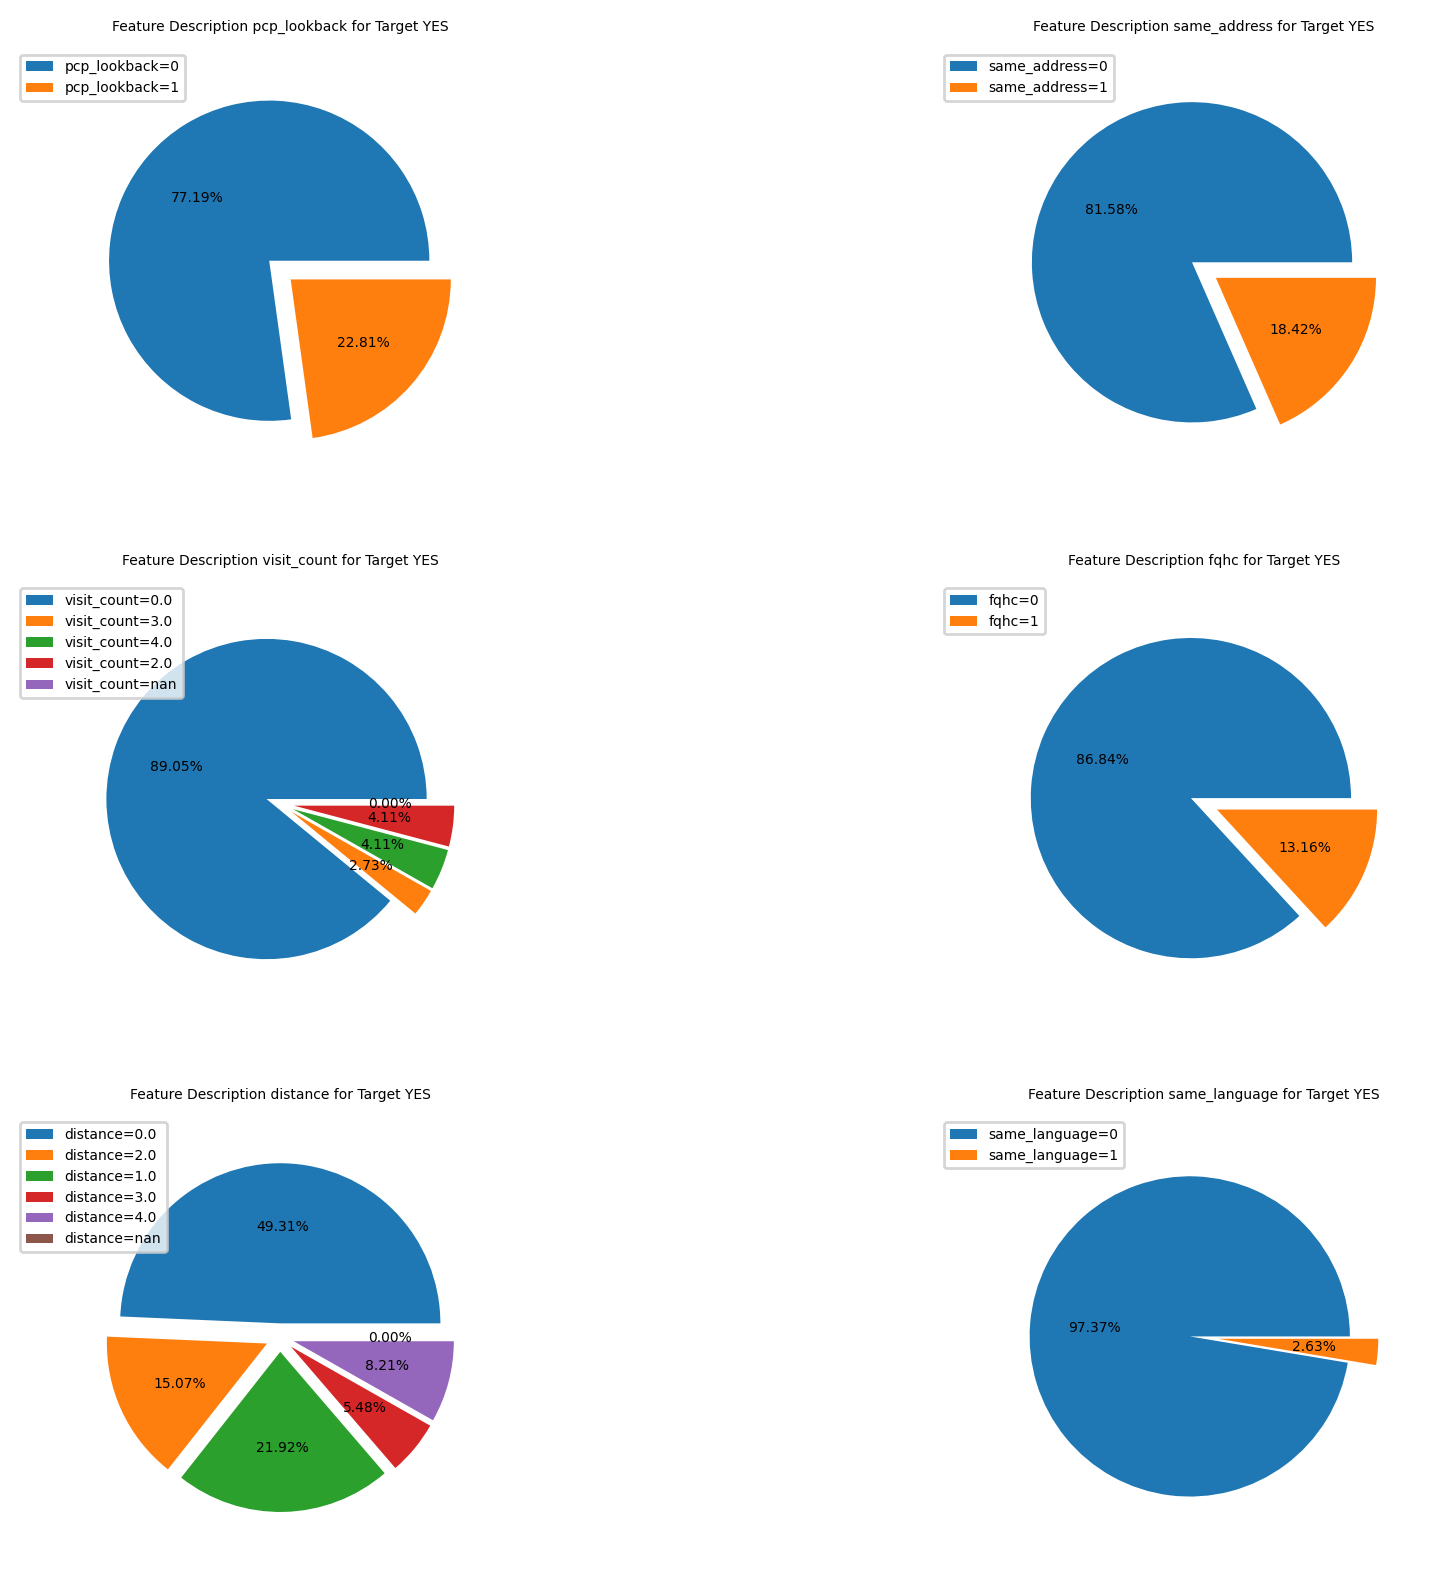

In [29]:
target_label='outcome'
report=compare_features(data,selected_features, target_label)
# print(report)
plot_data_from_report(report)
plt.show()

In [30]:
chosenModel="kNN"
featureVotes={}
for model in analysis:
  if model["name"]==chosenModel:
    for iteration_stats in model["stats_by_iteration"]:
      for feature in iteration_stats["selected_features"]:
        if feature not in featureVotes:
          featureVotes[feature]=0
        featureVotes[feature]+=1
# print(featureVotes)
selected_features=sorted(featureVotes, key=featureVotes.get,reverse=True)[:6]
print("Top 6 important features are {}".format(selected_features))

Top 6 important features are ['pcp_lookback', 'visit_count', 'same_language', 'same_address', 'distance', 'fqhc']


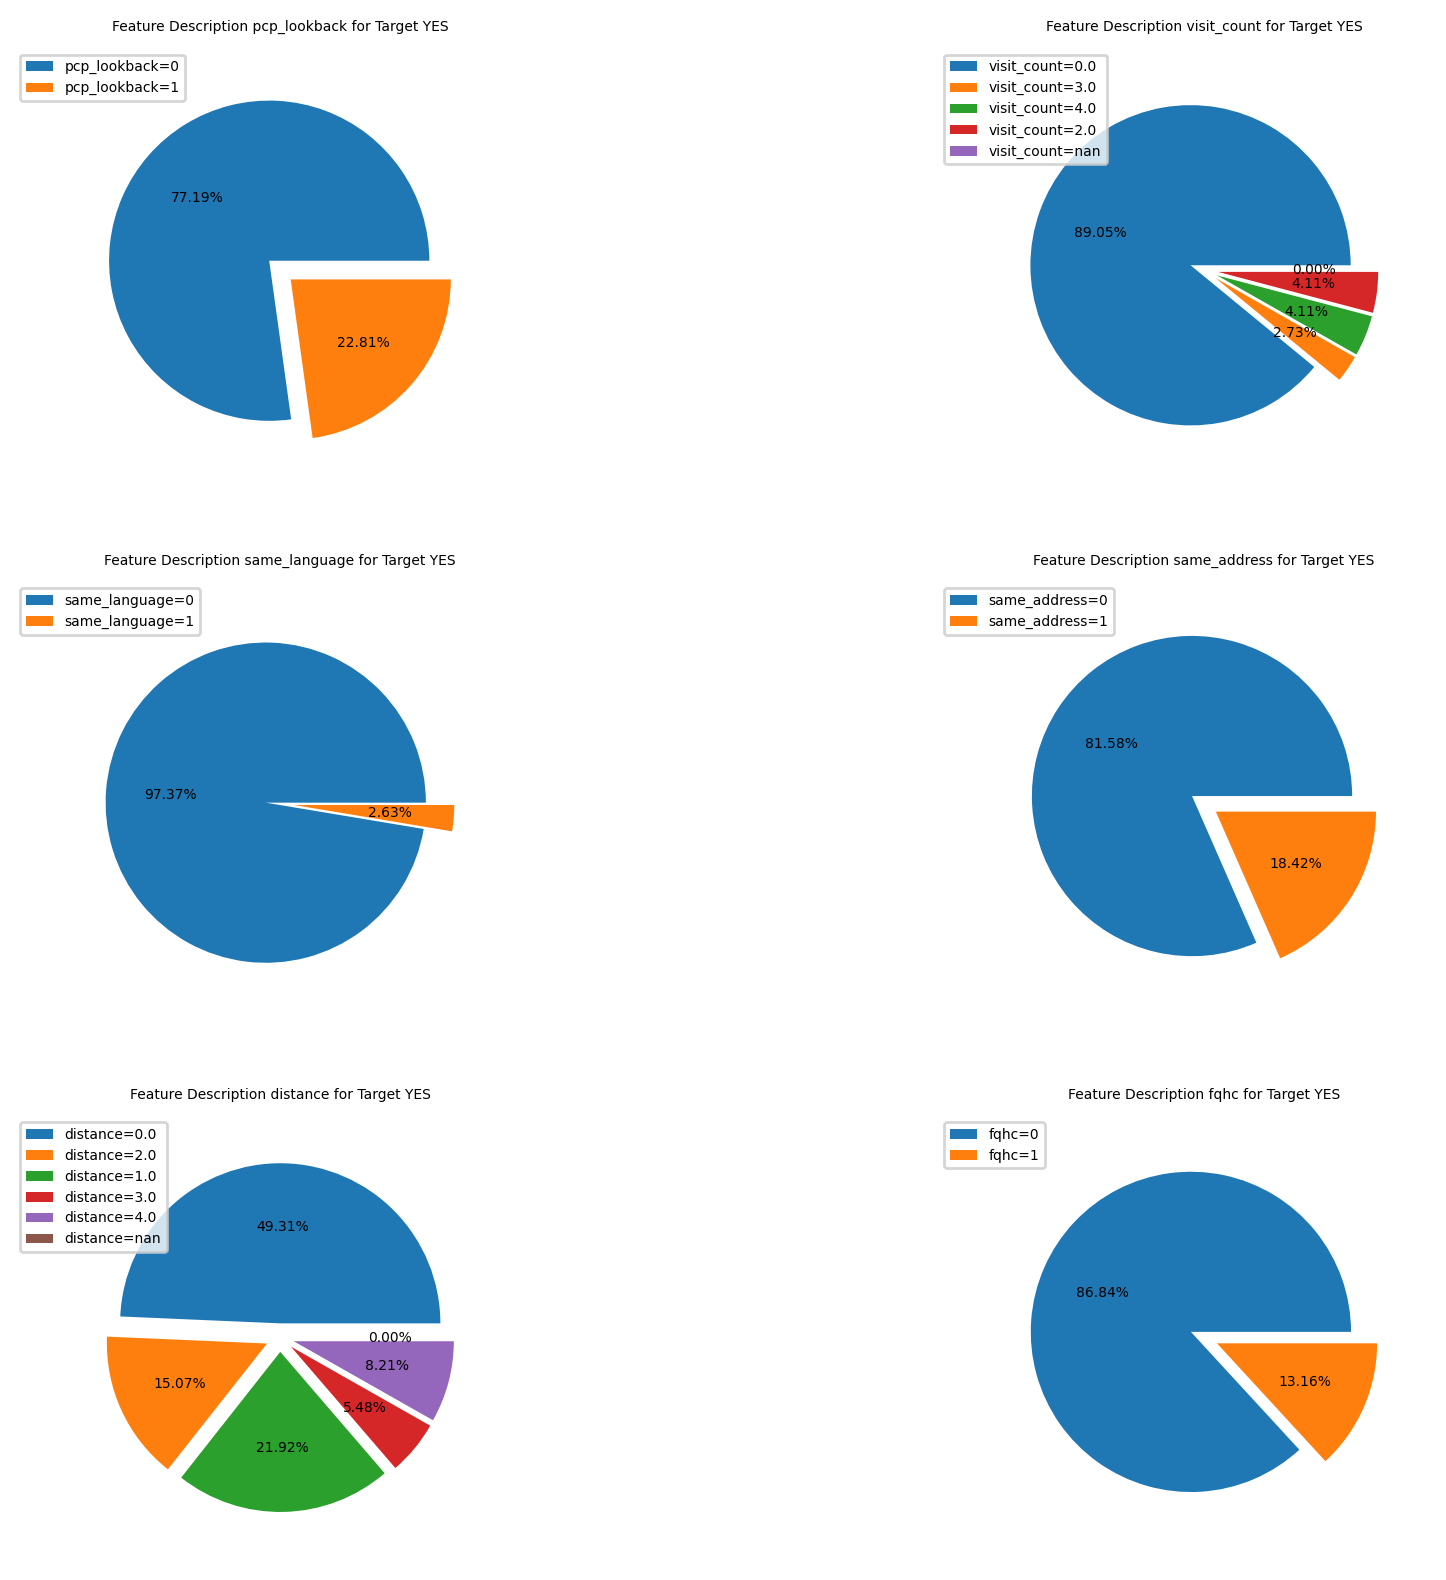

In [31]:
target_label='outcome'
report=compare_features(data,selected_features, target_label)
# print(report)
plot_data_from_report(report)
plt.show()

In [32]:
chosenModel="DecisionTree"
featureVotes={}
for model in analysis:
  if model["name"]==chosenModel:
    for iteration_stats in model["stats_by_iteration"]:
      for feature in iteration_stats["selected_features"]:
        if feature not in featureVotes:
          featureVotes[feature]=0
        featureVotes[feature]+=1
# print(featureVotes)
selected_features=sorted(featureVotes, key=featureVotes.get,reverse=True)[:6]
print("Top 6 important features are {}".format(selected_features))

Top 6 important features are ['pcp_lookback', 'visit_count', 'same_address', 'distance', 'fqhc', 'same_language']


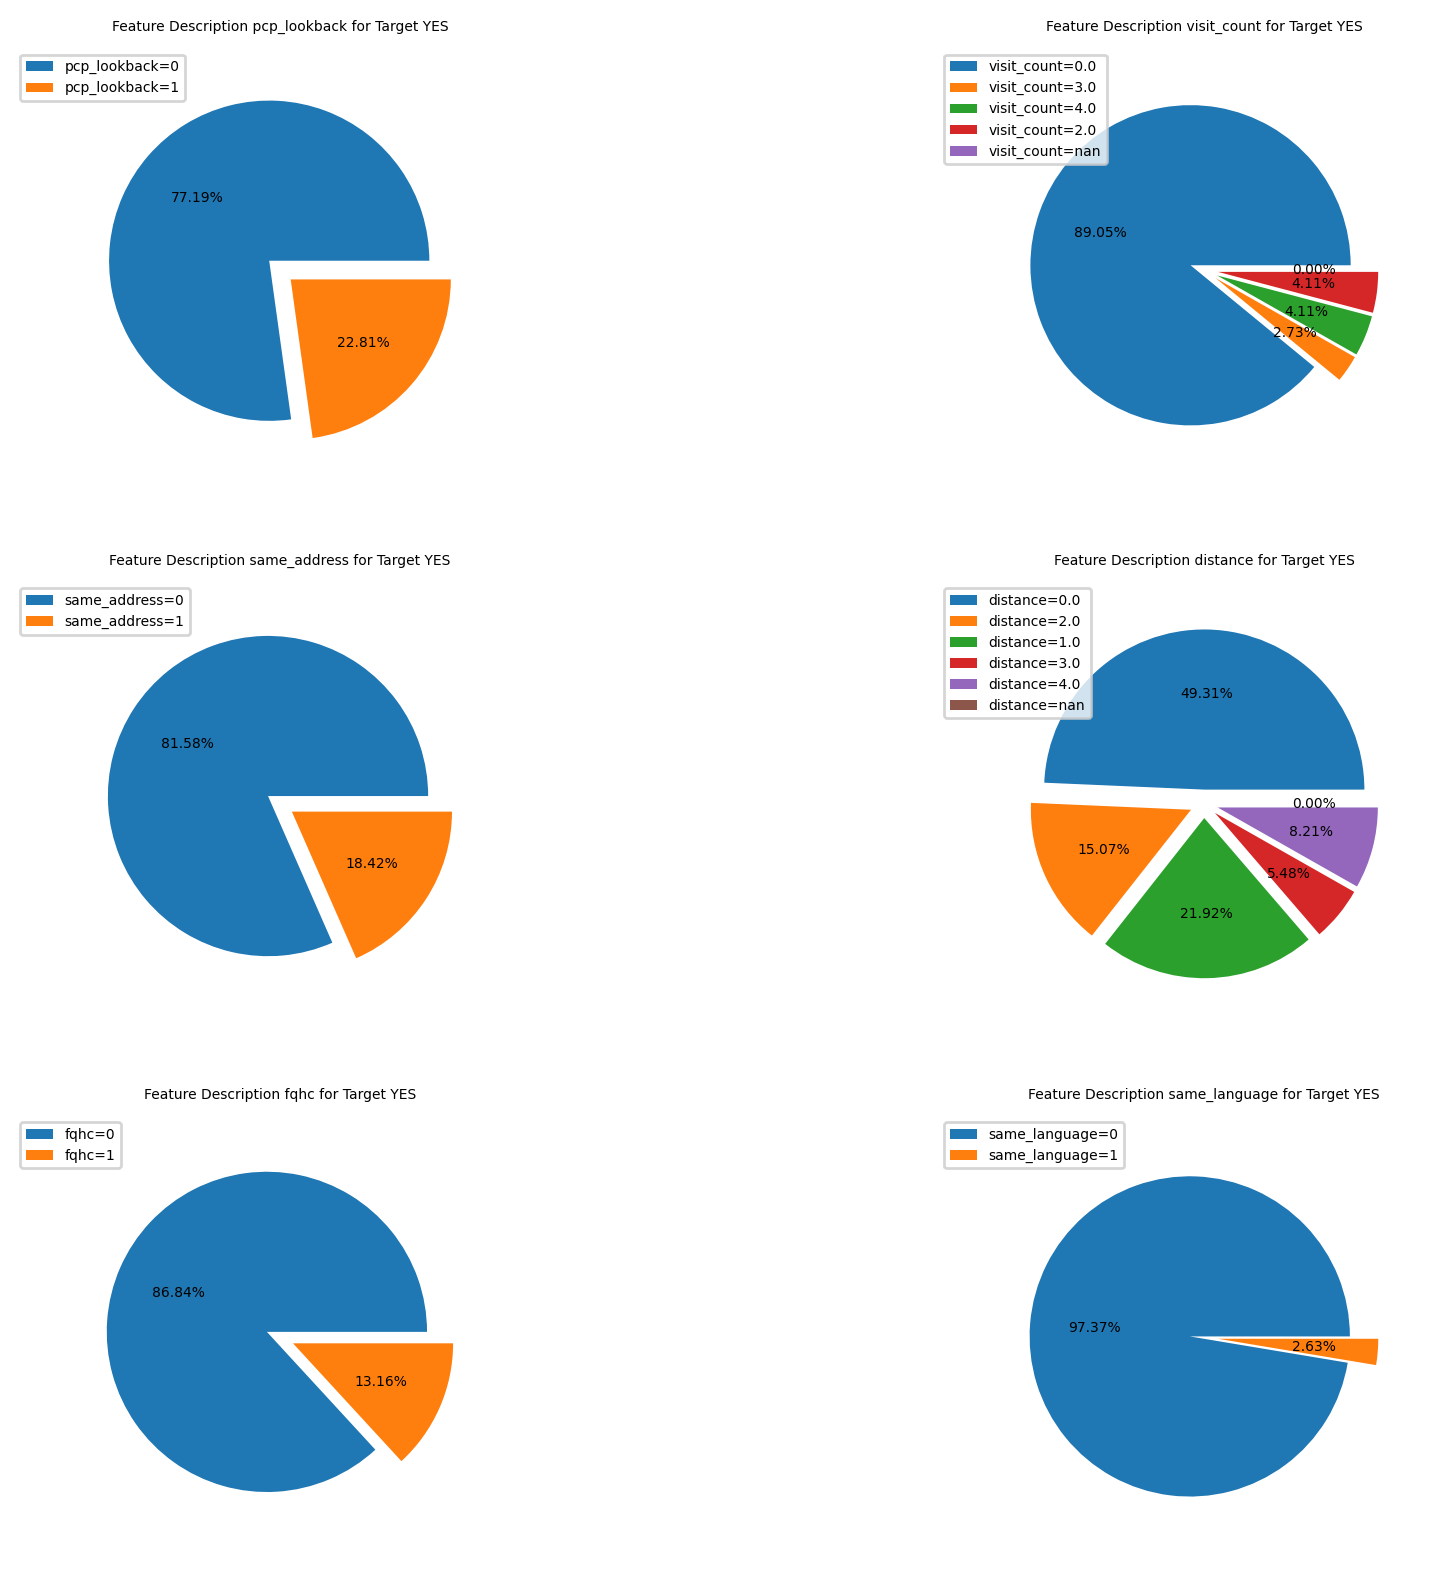

In [33]:
target_label='outcome'
report=compare_features(data,selected_features, target_label)
# print(report)
plot_data_from_report(report)
plt.show()

In [34]:
for i in analysis:
    print(i)

{'stats_by_iteration': [{'iteration': 1, 'repeat_number': 0, 'num_train_data': 2706, 'num_test_data': 301, 'selected_features': ['distance', 'visit_count', 'fqhc', 'pcp_lookback', 'same_language', 'same_address'], 'f0.5': 91.25}, {'iteration': 2, 'repeat_number': 0, 'num_train_data': 2706, 'num_test_data': 301, 'selected_features': ['distance', 'visit_count', 'fqhc', 'pcp_lookback', 'kid', 'same_address'], 'f0.5': 91.3}, {'iteration': 3, 'repeat_number': 0, 'num_train_data': 2706, 'num_test_data': 301, 'selected_features': ['distance', 'visit_count', 'fqhc', 'pcp_lookback', 'kid', 'same_address'], 'f0.5': 91.3}, {'iteration': 4, 'repeat_number': 0, 'num_train_data': 2706, 'num_test_data': 301, 'selected_features': ['distance', 'visit_count', 'fqhc', 'pcp_lookback', 'same_language', 'same_address'], 'f0.5': 89.23}, {'iteration': 5, 'repeat_number': 0, 'num_train_data': 2706, 'num_test_data': 301, 'selected_features': ['visit_count', 'fqhc', 'pcp_lookback', 'kid', 'same_language', 'same_

In [35]:
from sklearn.tree import DecisionTreeClassifier
import category_encoders as ce
from sklearn.model_selection import train_test_split

X = data.drop(['outcome'], axis=1)

y = data['outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)
X_train.shape, X_test.shape

((2014, 10), (993, 10))

In [36]:
X_train.dtypes

distance             float64
visit_count          float64
tier                 float64
fqhc                   int64
pcp_lookback           int64
family_assignment      int64
kid                    int64
same_gender            int64
same_language          int64
same_address           int64
dtype: object

In [37]:
X_train.head()

,distance,visit_count,tier,fqhc,pcp_lookback,family_assignment,kid,same_gender,same_language,same_address
testindex,,,,,,,,,,
2597,2.0,0.0,2.0,0,1,0,1,1,0,0
4539,NaN,NaN,1.0,0,0,0,0,0,0,0
1894,2.0,2.0,2.0,0,0,0,0,0,0,0
1364,2.0,4.0,2.0,0,1,0,0,1,0,0
1338,0.0,4.0,1.0,1,0,0,0,0,0,0


In [38]:
encoder = ce.OrdinalEncoder(cols=['distance','visit_count','tier', 'fqhc', 'pcp_lookback', 'family_assignment', 'kid', 'same_gender', 'same_language', 'same_address'])

In [39]:
X_train = encoder.fit_transform(X_train)

X_test = encoder.transform(X_test)
clf_gini = DecisionTreeClassifier(criterion='gini', max_depth=3, random_state=0)
clf_gini.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=0)

In [40]:
y_pred_gini = clf_gini.predict(X_test)

In [41]:
from sklearn.metrics import accuracy_score

print('Model accuracy score with criterion gini index: {0:0.4f}'. format(accuracy_score(y_test, y_pred_gini)))

Model accuracy score with criterion gini index: 0.9627


In [42]:
y_pred_train_gini = clf_gini.predict(X_train)

y_pred_train_gini

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [43]:
print('Training-set accuracy score: {0:0.4f}'. format(accuracy_score(y_train, y_pred_train_gini)))

Training-set accuracy score: 0.9623


In [44]:
# print the scores on training and test set

print('Training set score: {:.4f}'.format(clf_gini.score(X_train, y_train)))

print('Test set score: {:.4f}'.format(clf_gini.score(X_test, y_test)))

Training set score: 0.9623
Test set score: 0.9627


[Text(0.5, 0.875, 'X[9] <= 1.5\ngini = 0.074\nsamples = 2014\nvalue = [1936, 78]'),
 Text(0.25, 0.625, 'X[4] <= 1.5\ngini = 0.066\nsamples = 1886\nvalue = [1822, 64]'),
 Text(0.125, 0.375, 'X[2] <= 2.5\ngini = 0.035\nsamples = 781\nvalue = [767, 14]'),
 Text(0.0625, 0.125, 'gini = 0.046\nsamples = 552\nvalue = [539, 13]'),
 Text(0.1875, 0.125, 'gini = 0.009\nsamples = 229\nvalue = [228, 1]'),
 Text(0.375, 0.375, 'X[3] <= 1.5\ngini = 0.086\nsamples = 1105\nvalue = [1055, 50]'),
 Text(0.3125, 0.125, 'gini = 0.104\nsamples = 839\nvalue = [793, 46]'),
 Text(0.4375, 0.125, 'gini = 0.03\nsamples = 266\nvalue = [262, 4]'),
 Text(0.75, 0.625, 'X[2] <= 3.5\ngini = 0.195\nsamples = 128\nvalue = [114, 14]'),
 Text(0.625, 0.375, 'X[4] <= 1.5\ngini = 0.124\nsamples = 105\nvalue = [98, 7]'),
 Text(0.5625, 0.125, 'gini = 0.058\nsamples = 67\nvalue = [65, 2]'),
 Text(0.6875, 0.125, 'gini = 0.229\nsamples = 38\nvalue = [33, 5]'),
 Text(0.875, 0.375, 'X[4] <= 1.5\ngini = 0.423\nsamples = 23\nvalue = [16

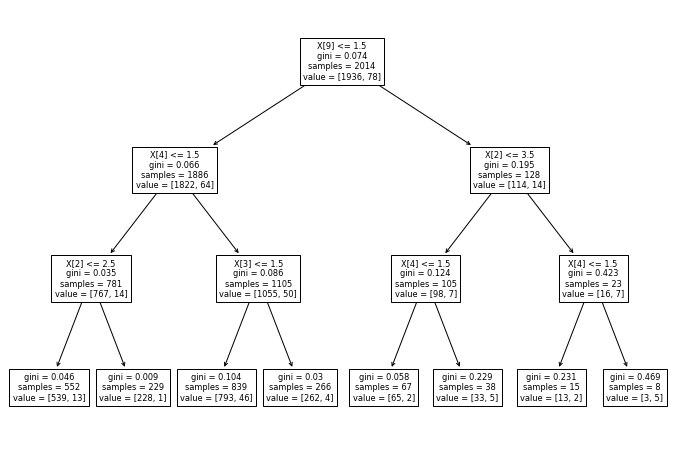

In [45]:
plt.figure(figsize=(12,8))

from sklearn import tree

tree.plot_tree(clf_gini.fit(X_train, y_train)) 

In [46]:
# instantiate the DecisionTreeClassifier model with criterion entropy

clf_en = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=0)


# fit the model
clf_en.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=0)

In [47]:
y_pred_en = clf_en.predict(X_test)

In [48]:
from sklearn.metrics import accuracy_score

print('Model accuracy score with criterion entropy: {0:0.4f}'. format(accuracy_score(y_test, y_pred_en)))

Model accuracy score with criterion entropy: 0.9627


In [49]:
y_pred_train_en = clf_en.predict(X_train)

y_pred_train_en

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [50]:
print('Training-set accuracy score: {0:0.4f}'. format(accuracy_score(y_train, y_pred_train_en)))

Training-set accuracy score: 0.9623


In [51]:
print('Training set score: {:.4f}'.format(clf_en.score(X_train, y_train)))

print('Test set score: {:.4f}'.format(clf_en.score(X_test, y_test)))

Training set score: 0.9623
Test set score: 0.9627


[Text(0.5, 0.875, 'X[4] <= 1.5\nentropy = 0.236\nsamples = 2014\nvalue = [1936, 78]'),
 Text(0.25, 0.625, 'X[0] <= 3.5\nentropy = 0.146\nsamples = 863\nvalue = [845, 18]'),
 Text(0.125, 0.375, 'X[0] <= 1.5\nentropy = 0.174\nsamples = 654\nvalue = [637, 17]'),
 Text(0.0625, 0.125, 'entropy = 0.0\nsamples = 61\nvalue = [61, 0]'),
 Text(0.1875, 0.125, 'entropy = 0.188\nsamples = 593\nvalue = [576, 17]'),
 Text(0.375, 0.375, 'X[2] <= 1.5\nentropy = 0.044\nsamples = 209\nvalue = [208, 1]'),
 Text(0.3125, 0.125, 'entropy = 0.135\nsamples = 53\nvalue = [52, 1]'),
 Text(0.4375, 0.125, 'entropy = 0.0\nsamples = 156\nvalue = [156, 0]'),
 Text(0.75, 0.625, 'X[9] <= 1.5\nentropy = 0.295\nsamples = 1151\nvalue = [1091, 60]'),
 Text(0.625, 0.375, 'X[3] <= 1.5\nentropy = 0.266\nsamples = 1105\nvalue = [1055, 50]'),
 Text(0.5625, 0.125, 'entropy = 0.307\nsamples = 839\nvalue = [793, 46]'),
 Text(0.6875, 0.125, 'entropy = 0.113\nsamples = 266\nvalue = [262, 4]'),
 Text(0.875, 0.375, 'X[2] <= 3.5\nentro

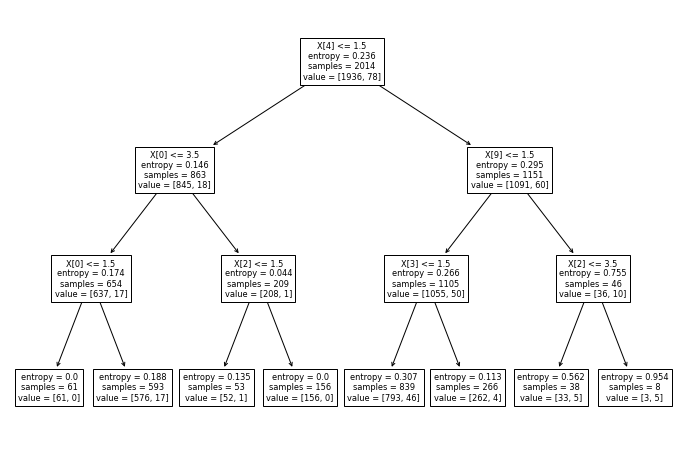

In [52]:
plt.figure(figsize=(12,8))

from sklearn import tree

tree.plot_tree(clf_en.fit(X_train, y_train)) 

In [53]:
# Print the Confusion Matrix and slice it into four pieces

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred_en)

print('Confusion matrix\n\n', cm)

Confusion matrix

 [[956   1]
 [ 36   0]]


In [54]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred_en))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       957
           1       0.00      0.00      0.00        36

    accuracy                           0.96       993
   macro avg       0.48      0.50      0.49       993
weighted avg       0.93      0.96      0.95       993

